In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/sample-sales-data/sales_data_sample.csv


In [2]:
import pandas as pd

df = pd.read_csv('/kaggle/input/sample-sales-data/sales_data_sample.csv', encoding='latin-1')

print("Shape of the data (rows, columns):", df.shape)
print("\n" + "="*50)

print("\nFirst 5 rows:")
print(df.head())

print("\n" + "="*50)
print("\nColumns in the dataset:")
print(df.columns.tolist())

print("\n" + "="*50)
print("\nData types:")
print(df.dtypes)

print("\n" + "="*50)
print("\nMissing values per column (sorted):")
print(df.isnull().sum().sort_values(ascending=False))

print("\n" + "="*50)
print("\nAny duplicate rows?")
print(df.duplicated().sum())

print("\n" + "="*50)
print("\nBasic statistics for numerical columns:")
print(df.describe())

Shape of the data (rows, columns): (2823, 25)


First 5 rows:
   ORDERNUMBER  QUANTITYORDERED  PRICEEACH  ORDERLINENUMBER    SALES  \
0        10107               30      95.70                2  2871.00   
1        10121               34      81.35                5  2765.90   
2        10134               41      94.74                2  3884.34   
3        10145               45      83.26                6  3746.70   
4        10159               49     100.00               14  5205.27   

         ORDERDATE   STATUS  QTR_ID  MONTH_ID  YEAR_ID  ...  \
0   2/24/2003 0:00  Shipped       1         2     2003  ...   
1    5/7/2003 0:00  Shipped       2         5     2003  ...   
2    7/1/2003 0:00  Shipped       3         7     2003  ...   
3   8/25/2003 0:00  Shipped       3         8     2003  ...   
4  10/10/2003 0:00  Shipped       4        10     2003  ...   

                    ADDRESSLINE1  ADDRESSLINE2           CITY STATE  \
0        897 Long Airport Avenue           NaN         

In [3]:
# Data Cleaning Steps

df['ORDERDATE'] = pd.to_datetime(df['ORDERDATE'], format='%m/%d/%Y %H:%M')

df['ADDRESSLINE2'] = df['ADDRESSLINE2'].fillna('Unknown')
df['STATE'] = df['STATE'].fillna('Unknown')
df['POSTALCODE'] = df['POSTALCODE'].fillna('Unknown')
df['TERRITORY'] = df['TERRITORY'].fillna('Unknown')


df['CALCULATED_SALES'] = df['QUANTITYORDERED'] * df['PRICEEACH']
difference = (df['SALES'] - df['CALCULATED_SALES']).abs().max()
print(f"Maximum difference between SALES and calculated: {difference}")

if difference == 0:
    df.drop('CALCULATED_SALES', axis=1, inplace=True)
    print("SALES column is perfectly consistent → dropped temporary column")
else:
    print("There are minor differences (possibly rounding)")

print("\n" + "="*50)
print("Data info after cleaning:")
print(df.info())
print("\nMissing values after cleaning:")
print(df.isnull().sum().sum(), "total missing values (should be 0)")

print("\nFirst 5 rows after cleaning:")
print(df.head())

Maximum difference between SALES and calculated: 7536.5
There are minor differences (possibly rounding)

Data info after cleaning:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2823 entries, 0 to 2822
Data columns (total 26 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   ORDERNUMBER       2823 non-null   int64         
 1   QUANTITYORDERED   2823 non-null   int64         
 2   PRICEEACH         2823 non-null   float64       
 3   ORDERLINENUMBER   2823 non-null   int64         
 4   SALES             2823 non-null   float64       
 5   ORDERDATE         2823 non-null   datetime64[ns]
 6   STATUS            2823 non-null   object        
 7   QTR_ID            2823 non-null   int64         
 8   MONTH_ID          2823 non-null   int64         
 9   YEAR_ID           2823 non-null   int64         
 10  PRODUCTLINE       2823 non-null   object        
 11  MSRP              2823 non-null   int64         
 12  P

In [4]:
df.drop('CALCULATED_SALES', axis=1, inplace=True)

print("Final shape after cleaning:", df.shape)
print("\nFinal columns:")
print(df.columns.tolist())

print("\nData types after cleaning:")
print(df.dtypes)

df.to_csv('/kaggle/working/sales_data_cleaned.csv', index=False)
print("\nCleaned data saved to /kaggle/working/sales_data_cleaned.csv")

Final shape after cleaning: (2823, 25)

Final columns:
['ORDERNUMBER', 'QUANTITYORDERED', 'PRICEEACH', 'ORDERLINENUMBER', 'SALES', 'ORDERDATE', 'STATUS', 'QTR_ID', 'MONTH_ID', 'YEAR_ID', 'PRODUCTLINE', 'MSRP', 'PRODUCTCODE', 'CUSTOMERNAME', 'PHONE', 'ADDRESSLINE1', 'ADDRESSLINE2', 'CITY', 'STATE', 'POSTALCODE', 'COUNTRY', 'TERRITORY', 'CONTACTLASTNAME', 'CONTACTFIRSTNAME', 'DEALSIZE']

Data types after cleaning:
ORDERNUMBER                  int64
QUANTITYORDERED              int64
PRICEEACH                  float64
ORDERLINENUMBER              int64
SALES                      float64
ORDERDATE           datetime64[ns]
STATUS                      object
QTR_ID                       int64
MONTH_ID                     int64
YEAR_ID                      int64
PRODUCTLINE                 object
MSRP                         int64
PRODUCTCODE                 object
CUSTOMERNAME                object
PHONE                       object
ADDRESSLINE1                object
ADDRESSLINE2            

In [7]:
import sqlite3
import pandas as pd

conn = sqlite3.connect('/kaggle/working/sales_database.db')
cursor = conn.cursor()

cursor.execute('DROP TABLE IF EXISTS Orders')
cursor.execute('DROP TABLE IF EXISTS Customers')
cursor.execute('DROP TABLE IF EXISTS Products')

cursor.execute('''
CREATE TABLE Products (
    product_id INTEGER PRIMARY KEY AUTOINCREMENT,
    product_code TEXT UNIQUE NOT NULL,
    product_line TEXT,
    msrp REAL
)
''')

cursor.execute('''
CREATE TABLE Customers (
    customer_id INTEGER PRIMARY KEY AUTOINCREMENT,
    customer_name TEXT UNIQUE NOT NULL,
    phone TEXT,
    address_line1 TEXT,
    address_line2 TEXT,
    city TEXT,
    state TEXT,
    postal_code TEXT,
    country TEXT,
    territory TEXT,
    contact_last_name TEXT,
    contact_first_name TEXT
)
''')

cursor.execute('''
CREATE TABLE Orders (
    order_number INTEGER,
    order_line_number INTEGER,
    order_date DATE,
    status TEXT,
    qtr_id INTEGER,
    month_id INTEGER,
    year_id INTEGER,
    quantity_ordered INTEGER,
    price_each REAL,
    sales REAL,
    deal_size TEXT,
    customer_id INTEGER,
    product_id INTEGER,
    PRIMARY KEY (order_number, order_line_number)
)
''')

products_unique = df[['PRODUCTCODE', 'PRODUCTLINE', 'MSRP']].drop_duplicates().reset_index(drop=True)
products_unique.rename(columns={'PRODUCTCODE': 'product_code', 'PRODUCTLINE': 'product_line', 'MSRP': 'msrp'}, inplace=True)
products_unique.to_sql('Products', conn, if_exists='append', index_label='product_id', index=True)

customers_unique = df[['CUSTOMERNAME', 'PHONE', 'ADDRESSLINE1', 'ADDRESSLINE2', 'CITY', 'STATE', 'POSTALCODE', 'COUNTRY', 'TERRITORY', 'CONTACTLASTNAME', 'CONTACTFIRSTNAME']].drop_duplicates().reset_index(drop=True)
customers_unique.rename(columns={
    'CUSTOMERNAME': 'customer_name',
    'PHONE': 'phone',
    'ADDRESSLINE1': 'address_line1',
    'ADDRESSLINE2': 'address_line2',
    'CITY': 'city',
    'STATE': 'state',
    'POSTALCODE': 'postal_code',
    'COUNTRY': 'country',
    'TERRITORY': 'territory',
    'CONTACTLASTNAME': 'contact_last_name',
    'CONTACTFIRSTNAME': 'contact_first_name'
}, inplace=True)
customers_unique.to_sql('Customers', conn, if_exists='append', index_label='customer_id', index=True)

product_id_map = pd.read_sql("SELECT product_id, product_code FROM Products", conn).set_index('product_code')['product_id'].to_dict()
customer_id_map = pd.read_sql("SELECT customer_id, customer_name FROM Customers", conn).set_index('customer_name')['customer_id'].to_dict()

df['product_id'] = df['PRODUCTCODE'].map(product_id_map)
df['customer_id'] = df['CUSTOMERNAME'].map(customer_id_map)

orders_data = df[['ORDERNUMBER', 'ORDERLINENUMBER', 'ORDERDATE', 'STATUS', 'QTR_ID', 'MONTH_ID', 'YEAR_ID',
                  'QUANTITYORDERED', 'PRICEEACH', 'SALES', 'DEALSIZE', 'customer_id', 'product_id']]

orders_data.rename(columns={
    'ORDERNUMBER': 'order_number',
    'ORDERLINENUMBER': 'order_line_number',
    'ORDERDATE': 'order_date',
    'STATUS': 'status',
    'QTR_ID': 'qtr_id',
    'MONTH_ID': 'month_id',
    'YEAR_ID': 'year_id',
    'QUANTITYORDERED': 'quantity_ordered',
    'PRICEEACH': 'price_each',
    'SALES': 'sales',
    'DEALSIZE': 'deal_size'
}, inplace=True)

orders_data.to_sql('Orders', conn, if_exists='append', index=False)

print("Products:", pd.read_sql("SELECT COUNT(*) FROM Products", conn).iloc[0,0])
print("Customers:", pd.read_sql("SELECT COUNT(*) FROM Customers", conn).iloc[0,0])
print("Orders:", pd.read_sql("SELECT COUNT(*) FROM Orders", conn).iloc[0,0])

test_query = pd.read_sql('''
SELECT o.order_number, o.order_date, c.customer_name, p.product_line, o.quantity_ordered, o.sales
FROM Orders o
JOIN Customers c ON o.customer_id = c.customer_id
JOIN Products p ON o.product_id = p.product_id
LIMIT 5
''', conn)

print(test_query)

conn.commit()
conn.close()

Products: 109
Customers: 92
Orders: 2823
   order_number           order_date             customer_name product_line  \
0         10107  2003-02-24 00:00:00         Land of Toys Inc.  Motorcycles   
1         10121  2003-05-07 00:00:00        Reims Collectables  Motorcycles   
2         10134  2003-07-01 00:00:00           Lyon Souveniers  Motorcycles   
3         10145  2003-08-25 00:00:00         Toys4GrownUps.com  Motorcycles   
4         10159  2003-10-10 00:00:00  Corporate Gift Ideas Co.  Motorcycles   

   quantity_ordered    sales  
0                30  2871.00  
1                34  2765.90  
2                41  3884.34  
3                45  3746.70  
4                49  5205.27  


/tmp/ipykernel_47/2286738422.py:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  orders_data.rename(columns={


In [8]:
import sqlite3
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

conn = sqlite3.connect('/kaggle/working/sales_database.db')

sales_by_product_country = pd.read_sql('''
SELECT 
    p.product_line,
    c.country,
    ROUND(SUM(o.sales), 2) AS total_sales,
    SUM(o.quantity_ordered) AS total_quantity,
    COUNT(*) AS number_of_orders
FROM Orders o
JOIN Products p ON o.product_id = p.product_id
JOIN Customers c ON o.customer_id = c.customer_id
GROUP BY p.product_line, c.country
ORDER BY total_sales DESC
LIMIT 20
''', conn)

print("Top 20 Product Line Sales by Country")
print(sales_by_product_country)

deal_size_by_quarter = pd.read_sql('''
SELECT 
    o.year_id,
    o.qtr_id,
    o.deal_size,
    ROUND(SUM(o.sales), 2) AS total_sales,
    COUNT(*) AS number_of_deals
FROM Orders o
GROUP BY o.year_id, o.qtr_id, o.deal_size
ORDER BY o.year_id, o.qtr_id, total_sales DESC
''', conn)

print("\nDeal Size Distribution by Year and Quarter")
print(deal_size_by_quarter)

top_customers = pd.read_sql('''
SELECT 
    c.customer_name,
    c.country,
    ROUND(SUM(o.sales), 2) AS total_sales,
    COUNT(DISTINCT o.order_number) AS number_of_orders,
    ROUND(AVG(o.sales), 2) AS avg_order_value
FROM Orders o
JOIN Customers c ON o.customer_id = c.customer_id
GROUP BY c.customer_name
ORDER BY total_sales DESC
LIMIT 10
''', conn)

print("\nTop 10 Customers by Total Sales")
print(top_customers)

conn.close()

Top 20 Product Line Sales by Country
        product_line    country  total_sales  total_quantity  number_of_orders
0       Classic Cars        USA   1344638.22           11625               329
1       Vintage Cars        USA    757755.90            8239               224
2        Motorcycles        USA    520371.70            5080               149
3       Classic Cars      Spain    476165.15            4380               120
4   Trucks and Buses        USA    397842.42            3932               112
5       Classic Cars     France    388951.20            3540                98
6             Planes        USA    328432.89            3476                95
7       Vintage Cars      Spain    229514.51            2562                74
8        Motorcycles     France    226390.31            2404                68
9              Ships        USA    209688.14            2395                70
10      Classic Cars  Australia    193085.54            1818                53
11      Vintage

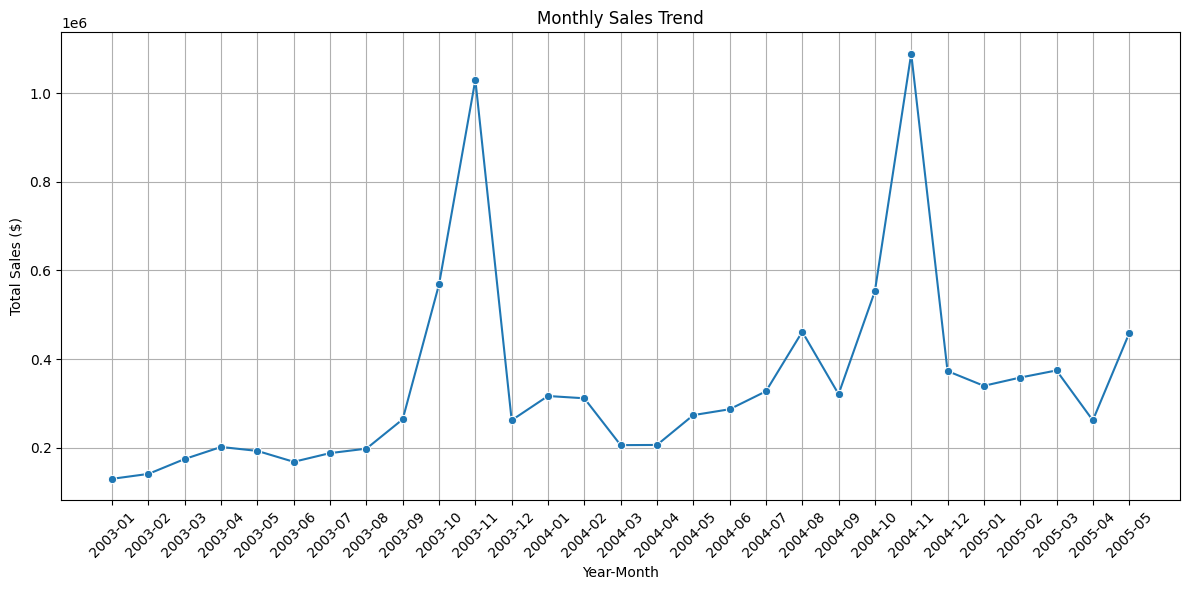

RFM Analysis - Top 20 Customers by Monetary Value
                   customer_name  recency_days  frequency   monetary  r_score  \
0          Euro Shopping Channel           1.0         26  912294.11        1   
1   Mini Gifts Distributors Ltd.           3.0         17  654858.06        1   
2     Australian Collectors, Co.         184.0          5  200995.41        3   
3             Muscle Machine Inc         182.0          4  197736.94        3   
4              La Rochelle Gifts           1.0          4  180124.90        1   
5        Dragon Souveniers, Ltd.          91.0          5  172989.68        2   
6              Land of Toys Inc.         198.0          4  164069.44        3   
7      The Sharp Gifts Warehouse          40.0          4  160010.27        1   
8                 AV Stores, Co.         196.0          3  157807.81        3   
9        Anna's Decorations, Ltd          84.0          4  153996.13        2   
10     Souveniers And Things Co.           3.0          4  

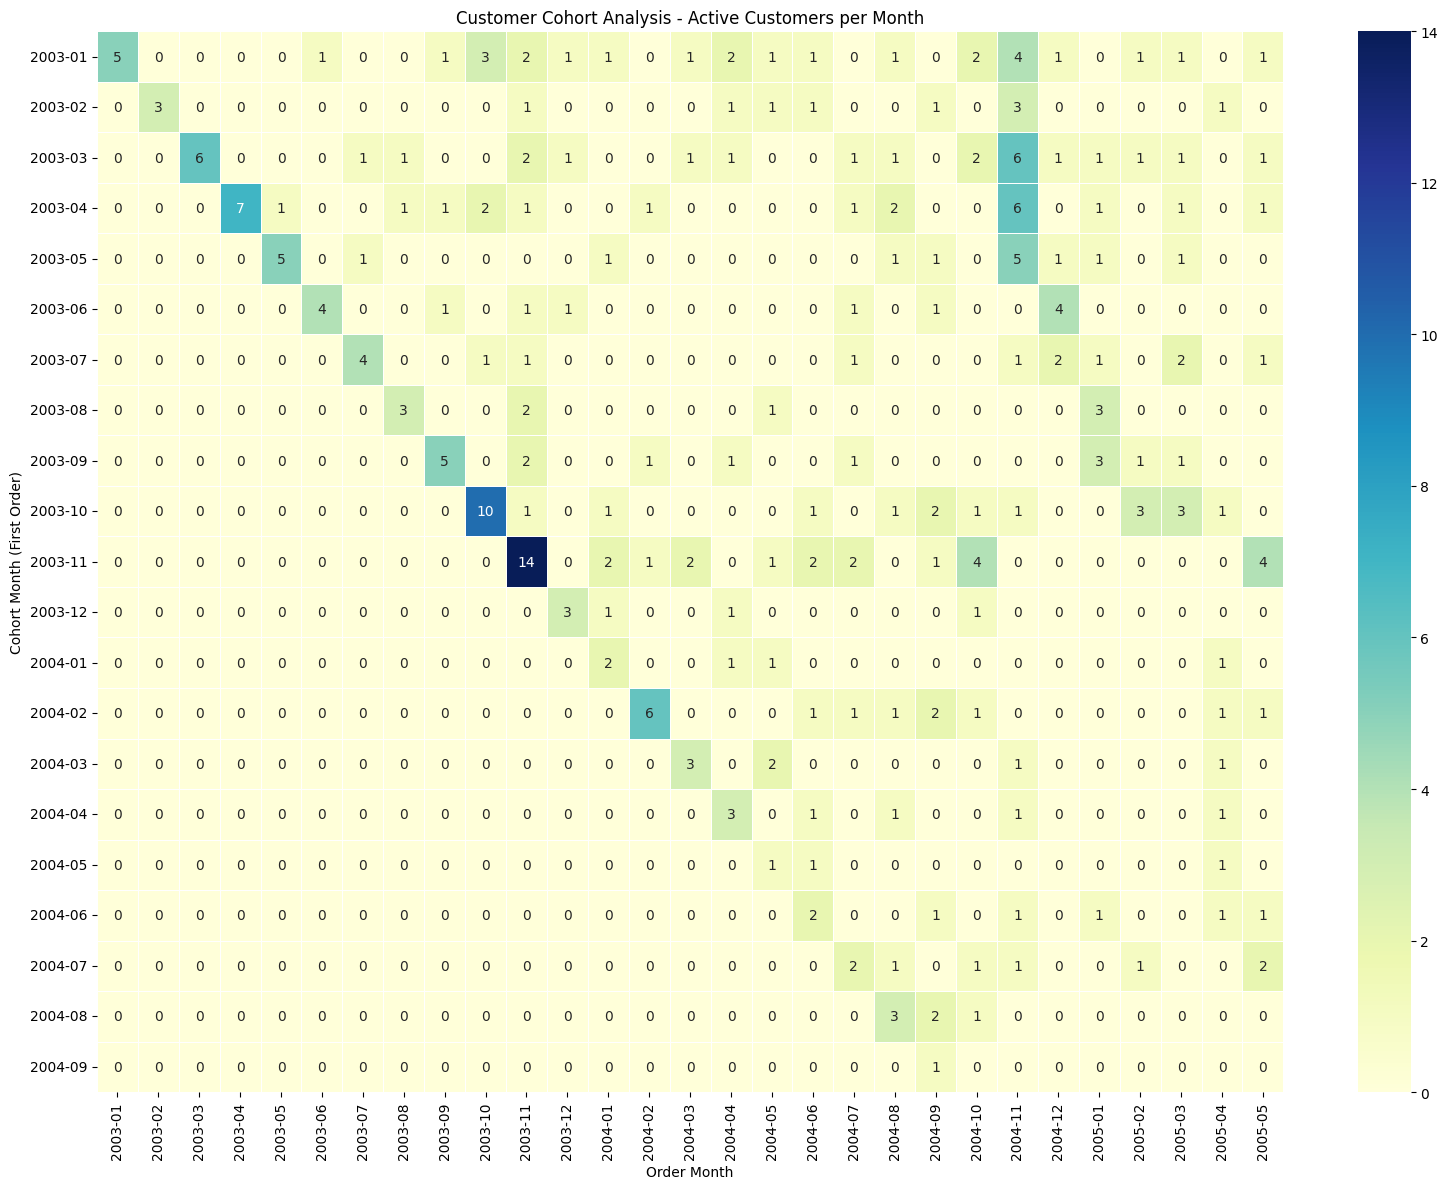

In [10]:
import sqlite3
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

conn = sqlite3.connect('/kaggle/working/sales_database.db')

monthly_sales = pd.read_sql('''
SELECT 
    o.year_id || '-' || printf("%02d", o.month_id) AS year_month,
    ROUND(SUM(o.sales), 2) AS total_sales
FROM Orders o
GROUP BY o.year_id, o.month_id
ORDER BY o.year_id, o.month_id
''', conn)

plt.figure(figsize=(12,6))
sns.lineplot(data=monthly_sales, x='year_month', y='total_sales', marker='o')
plt.title('Monthly Sales Trend')
plt.xticks(rotation=45)
plt.ylabel('Total Sales ($)')
plt.xlabel('Year-Month')
plt.grid(True)
plt.tight_layout()
plt.show()

rfm = pd.read_sql('''
WITH rfm_calc AS (
    SELECT 
        c.customer_name,
        MAX(o.order_date) AS last_order_date,
        COUNT(DISTINCT o.order_number) AS frequency,
        ROUND(SUM(o.sales), 2) AS monetary
    FROM Orders o
    JOIN Customers c ON o.customer_id = c.customer_id
    GROUP BY c.customer_name
),
recency_days AS (
    SELECT 
        customer_name,
        JULIANDAY('2005-06-01') - JULIANDAY(last_order_date) AS recency,
        frequency,
        monetary
    FROM rfm_calc
)
SELECT 
    customer_name,
    ROUND(recency, 1) AS recency_days,
    frequency,
    monetary,
    NTILE(5) OVER (ORDER BY recency ASC) AS r_score,
    NTILE(5) OVER (ORDER BY frequency DESC) AS f_score,
    NTILE(5) OVER (ORDER BY monetary DESC) AS m_score
FROM recency_days
ORDER BY monetary DESC
LIMIT 20
''', conn)

print("RFM Analysis - Top 20 Customers by Monetary Value")
print(rfm)

cohort = pd.read_sql('''
WITH first_order AS (
    SELECT 
        customer_id,
        MIN(order_date) AS first_order_date
    FROM Orders
    GROUP BY customer_id
),
cohort_month AS (
    SELECT 
        o.customer_id,
        strftime('%Y-%m', f.first_order_date) AS cohort_month,
        strftime('%Y-%m', o.order_date) AS order_month
    FROM Orders o
    JOIN first_order f ON o.customer_id = f.customer_id
),
cohort_counts AS (
    SELECT 
        cohort_month,
        order_month,
        COUNT(DISTINCT customer_id) AS active_customers
    FROM cohort_month
    GROUP BY cohort_month, order_month
)
SELECT 
    cohort_month,
    order_month,
    active_customers
FROM cohort_counts
ORDER BY cohort_month, order_month
''', conn)

cohort_pivot = cohort.pivot(index='cohort_month', columns='order_month', values='active_customers').fillna(0)

plt.figure(figsize=(16,12))
sns.heatmap(cohort_pivot, annot=True, fmt='.0f', cmap='YlGnBu', linewidths=.5)
plt.title('Customer Cohort Analysis - Active Customers per Month')
plt.ylabel('Cohort Month (First Order)')
plt.xlabel('Order Month')
plt.tight_layout()
plt.show()

conn.close()

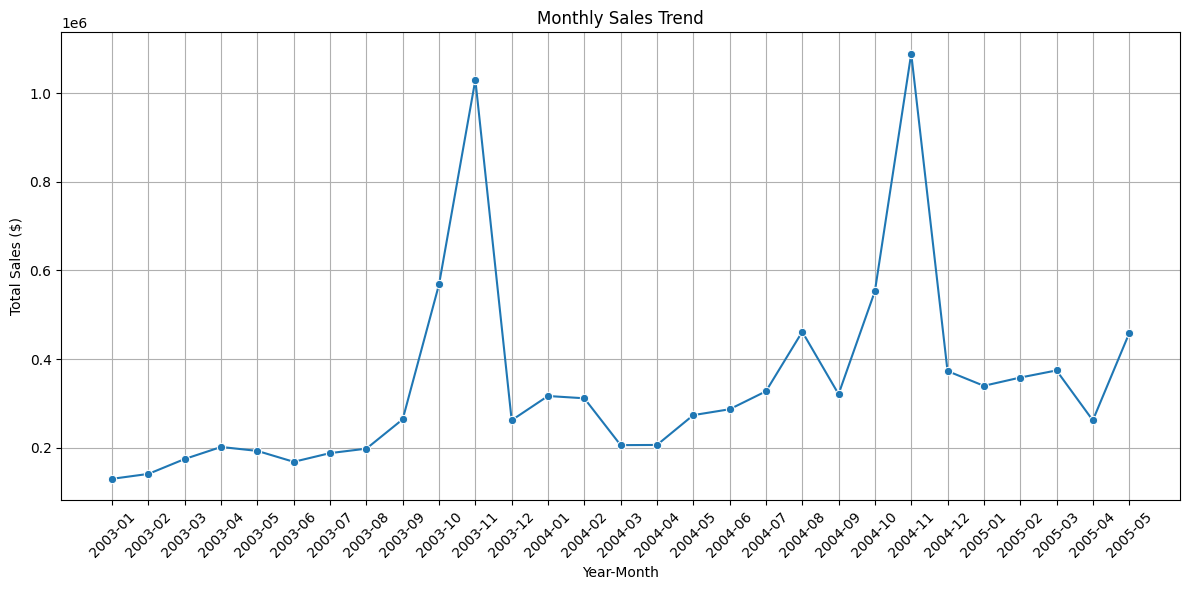

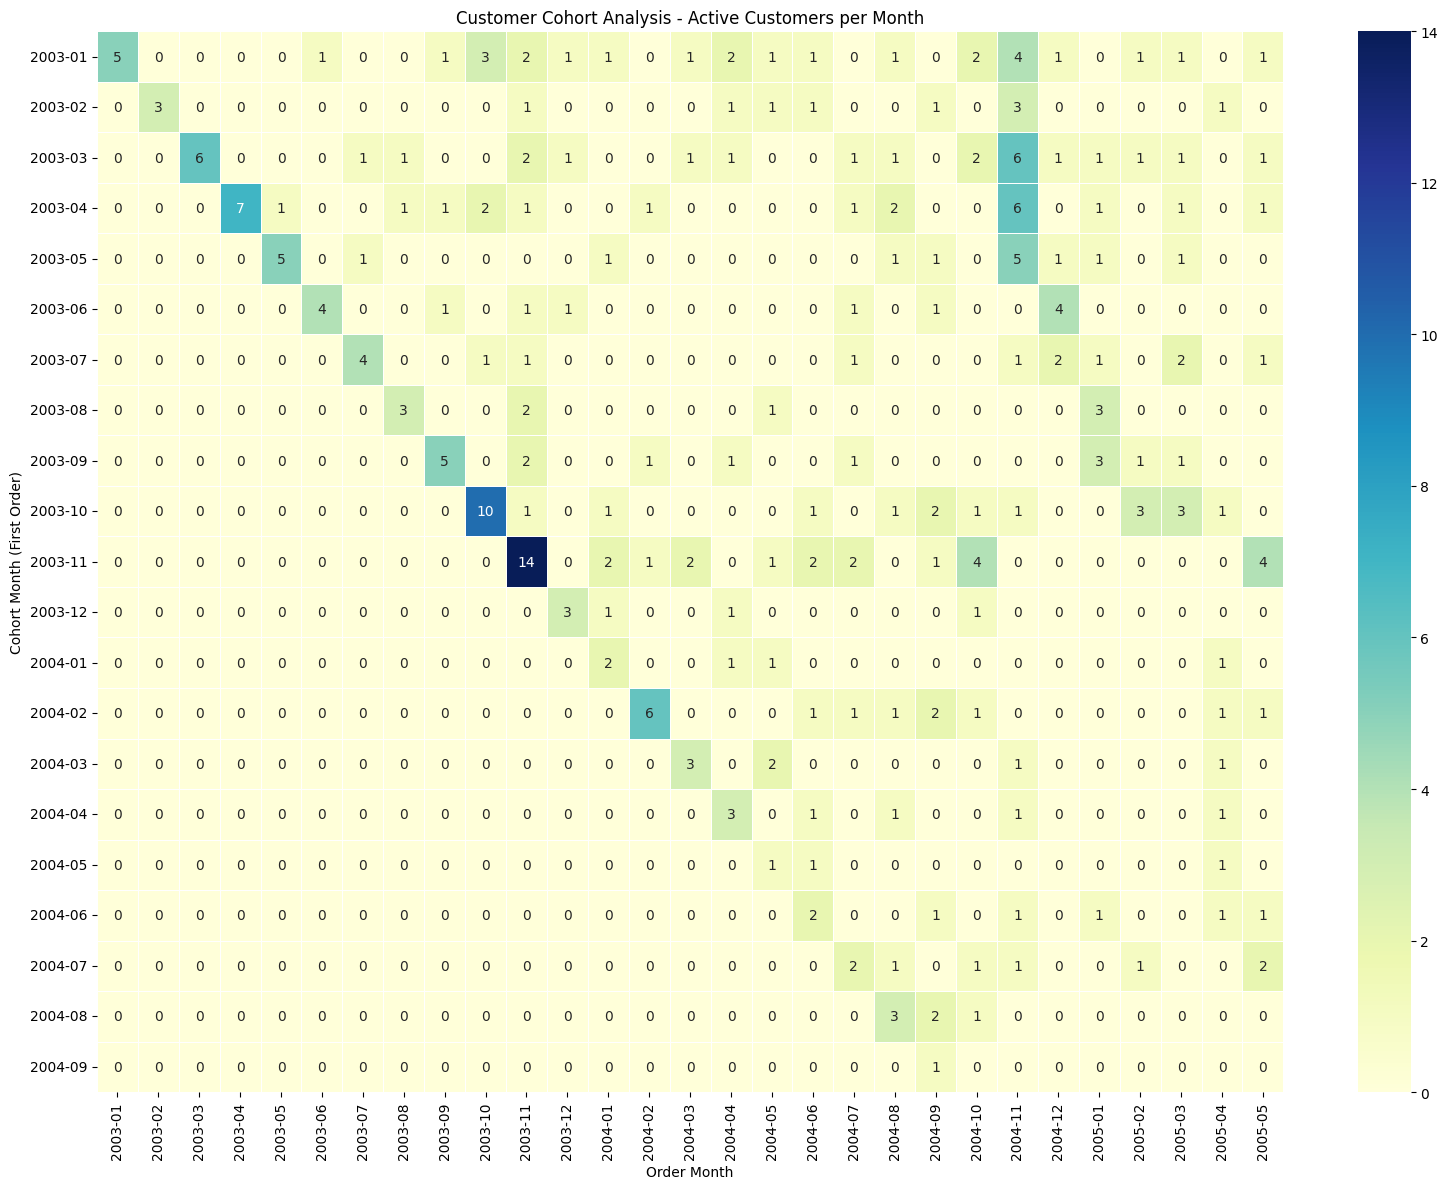

All charts saved successfully:
- monthly_sales_trend.png
- cohort_analysis_heatmap.png
Plus the cleaned CSV and SQLite DB are in /kaggle/working/


In [11]:
import sqlite3
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

conn = sqlite3.connect('/kaggle/working/sales_database.db')

monthly_sales = pd.read_sql('''
SELECT 
    o.year_id || '-' || printf("%02d", o.month_id) AS year_month,
    ROUND(SUM(o.sales), 2) AS total_sales
FROM Orders o
GROUP BY o.year_id, o.month_id
ORDER BY o.year_id, o.month_id
''', conn)

plt.figure(figsize=(12,6))
sns.lineplot(data=monthly_sales, x='year_month', y='total_sales', marker='o')
plt.title('Monthly Sales Trend')
plt.xticks(rotation=45)
plt.ylabel('Total Sales ($)')
plt.xlabel('Year-Month')
plt.grid(True)
plt.tight_layout()
plt.savefig('/kaggle/working/monthly_sales_trend.png')
plt.show()

cohort = pd.read_sql('''
WITH first_order AS (
    SELECT 
        customer_id,
        MIN(order_date) AS first_order_date
    FROM Orders
    GROUP BY customer_id
),
cohort_month AS (
    SELECT 
        o.customer_id,
        strftime('%Y-%m', f.first_order_date) AS cohort_month,
        strftime('%Y-%m', o.order_date) AS order_month
    FROM Orders o
    JOIN first_order f ON o.customer_id = f.customer_id
),
cohort_counts AS (
    SELECT 
        cohort_month,
        order_month,
        COUNT(DISTINCT customer_id) AS active_customers
    FROM cohort_month
    GROUP BY cohort_month, order_month
)
SELECT 
    cohort_month,
    order_month,
    active_customers
FROM cohort_counts
ORDER BY cohort_month, order_month
''', conn)

cohort_pivot = cohort.pivot(index='cohort_month', columns='order_month', values='active_customers').fillna(0)

plt.figure(figsize=(16,12))
sns.heatmap(cohort_pivot, annot=True, fmt='.0f', cmap='YlGnBu', linewidths=.5)
plt.title('Customer Cohort Analysis - Active Customers per Month')
plt.ylabel('Cohort Month (First Order)')
plt.xlabel('Order Month')
plt.tight_layout()
plt.savefig('/kaggle/working/cohort_analysis_heatmap.png')
plt.show()

conn.close()

print("All charts saved successfully:")
print("- monthly_sales_trend.png")
print("- cohort_analysis_heatmap.png")
print("Plus the cleaned CSV and SQLite DB are in /kaggle/working/")